## CQ1.7 - Gene-Gene Phenotype Similarity for FA Genes

Description: https://docs.google.com/document/d/10wvsoNLbbFOvHWVWRdYQdJ_PD0uO7SGGR-gIqCM8GWU/edit#

In [1]:
# autogenerate biolink_client
# curl --insecure -X POST -H "content-type:application/json" -d '{"swaggerUrl":"https://api.monarchinitiative.org/api/swagger.json"}' https://generator.swagger.io/api/gen/clients/python
# and rename it to biolink_client

In [2]:
import os, sys
# change this path
sys.path.insert(0, "/home/gstupp/projects/NCATS-Tangerine/biolink_client")

In [3]:
import biolink_client
from biolink_client.api_client import ApiClient
from biolink_client.rest import ApiException
import requests
from itertools import chain
from collections import Counter
import pandas as pd
from pprint import pprint
from tqdm import tqdm, tqdm_notebook
from collections import defaultdict

pd.options.display.max_rows = 999

MONARCH_API = "https://api.monarchinitiative.org/api"
SIMSEARCH_API = "https://monarchinitiative.org/simsearch/phenotype"

gene_list = "https://raw.githubusercontent.com/NCATS-Tangerine/cq-notebooks/master/FA_gene_sets/FA_4_all_genes.txt"

client = ApiClient(host=MONARCH_API)
client.set_default_header('Content-Type', 'text/plain')
api_instance = biolink_client.BioentityApi(client)

# Get the gene list from github
dataframe = pd.read_csv(gene_list, sep='\t', names=['gene_id', 'symbol'])
df = dataframe.set_index('symbol')
human_FA_genes = set(df.gene_id)

In [4]:
def get_obj(obj_id):
    url = "https://api.monarchinitiative.org/api/bioentity/{}".format(obj_id)
    res = requests.get(url)
    d = res.json()
    return d
def get_taxon_from_gene(gene):
    return get_obj(gene)['taxon']['label']
def get_phenotype_from_gene(gene):
    # https://monarchinitiative.org/gene/NCBIGene%3A2176/phenotype_list.json
    url = "https://monarchinitiative.org/gene/{}/phenotype_list.json"
    return [x['id'] for x in requests.get(url.format(gene)).json()['phenotype_list']]
def get_phenotype_from_gene_verbose(gene):
    # https://monarchinitiative.org/gene/NCBIGene%3A2176/phenotype_list.json
    url = "https://monarchinitiative.org/gene/{}/phenotype_list.json"
    return [(x['id'],x['label']) for x in requests.get(url.format(gene)).json()['phenotype_list']]
def query_orthologs(gene_id, taxon=None):
    """Query Monarch to determine the orthologs of a gene."""
    url = "https://api.monarchinitiative.org/api/bioentity/gene/{}/homologs/".format(gene_id)
    if taxon:
        res = requests.get(url, params={'homolog_taxon': taxon})
    else:        
        res = requests.get(url)
    d = res.json()
    return [x['object']['id'] for x in d['associations']]
#query_orthologs('MGI:88276', taxon="NCBITaxon:9606")
#get_phenotype_from_gene("NCBIGene:2176")
#get_taxon_from_gene('NCBIGene:2176')

In [5]:
def get_phenotypically_similar_genes(phenotypes, taxon, return_all=False):
    headers = {
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.8',
        'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8',
        'Accept': 'application/json, text/javascript, */*; q=0.01',
    }
    data = {'input_items': " ".join(phenotypes), "target_species": taxon}
    r = requests.post(SIMSEARCH_API, data=data, headers=headers)
    d = r.json()
    if return_all:
        return d
    if 'b' in d:
        scores = [(x['id'],x['score']['score'], x['label']) for x in d['b']]
    else:
        scores = []
    return scores
#get_phenotypically_similar_genes(phenotypes, "10090")

In [6]:
# 1. Retrieve set of phenotypes linked to each of the input human FA gene
gene_phenotypes = dict()
for gene in tqdm_notebook(human_FA_genes):
    phenotypes = get_phenotype_from_gene(gene)
    gene_phenotypes[gene] = phenotypes

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [7]:
# 2. Pool phenotypes from all profiles into a single set and remove dups to give list of non-redundant phenotypes
phenotypes = set(chain(*gene_phenotypes.values()))
print(list(phenotypes)[:5])
print(len(phenotypes))

['HP:0100012', 'HP:0100820', 'HP:0000126', 'HP:0001631', 'HP:0003214']
449


In [8]:
# 3. Use this set to execute a single cross-species phenosim analysis to compare against pheno profiles of 
# genes from 5 species (human, mouse, zebrafish, fly, worm)

# note: no human!!
taxids = [10090, 7955, 7227, 6239]
results = dict()
for taxid in taxids:
    response = get_phenotypically_similar_genes(phenotypes, taxid)
    results[taxid] = [{"id": r[0], "score": r[1], "symbol": r[2]} for r in response]

In [9]:
# 4. Remove FA genes from results (i.e. trim inputs)
# There's no human in here, so will do this after we get orthologs

In [10]:
# 5. Take top 25 results as gene ‘hits’
for taxid in results:
    print(taxid)
    print(results[taxid][:10])
# scores of each organism are very different, so I'll take the top X for each organism

7227
[]
10090
[{'id': 'MGI:1330810', 'symbol': 'Trp63', 'score': 66}, {'id': 'MGI:109583', 'symbol': 'Pten', 'score': 64}, {'id': 'MGI:88276', 'symbol': 'Ctnnb1', 'score': 63}, {'id': 'MGI:95523', 'symbol': 'Fgfr2', 'score': 62}, {'id': 'MGI:88039', 'symbol': 'Apc', 'score': 62}, {'id': 'MGI:98834', 'symbol': 'Trp53', 'score': 61}, {'id': 'MGI:99484', 'symbol': 'Chuk', 'score': 60}, {'id': 'MGI:98297', 'symbol': 'Shh', 'score': 60}, {'id': 'MGI:96680', 'symbol': 'Kras', 'score': 60}, {'id': 'MGI:1347466', 'symbol': 'Foxc1', 'score': 60}]
7955
[{'id': 'ZFIN:ZDB-GENE-031112-7', 'symbol': 'apc', 'score': 51}, {'id': 'ZFIN:ZDB-GENE-080405-1', 'symbol': 'tert', 'score': 49}, {'id': 'ZFIN:ZDB-GENE-011026-1', 'symbol': 'sox32', 'score': 48}, {'id': 'ZFIN:ZDB-GENE-060125-1', 'symbol': 'med12', 'score': 48}, {'id': 'ZFIN:ZDB-GENE-030131-9685', 'symbol': 'ddx18', 'score': 47}, {'id': 'ZFIN:ZDB-GENE-011010-3', 'symbol': 'aldh1a2', 'score': 47}, {'id': 'ZFIN:ZDB-GENE-990615-5', 'symbol': 'tbx16', 

In [11]:
results = {k:sorted(v, key=lambda x:x['score'], reverse=True)[:10] for k,v in results.items()}

In [12]:
results_list = list(chain(*results.values()))
results_list

[{'id': 'ZFIN:ZDB-GENE-031112-7', 'score': 51, 'symbol': 'apc'},
 {'id': 'ZFIN:ZDB-GENE-080405-1', 'score': 49, 'symbol': 'tert'},
 {'id': 'ZFIN:ZDB-GENE-011026-1', 'score': 48, 'symbol': 'sox32'},
 {'id': 'ZFIN:ZDB-GENE-060125-1', 'score': 48, 'symbol': 'med12'},
 {'id': 'ZFIN:ZDB-GENE-030131-9685', 'score': 47, 'symbol': 'ddx18'},
 {'id': 'ZFIN:ZDB-GENE-011010-3', 'score': 47, 'symbol': 'aldh1a2'},
 {'id': 'ZFIN:ZDB-GENE-990615-5', 'score': 46, 'symbol': 'tbx16'},
 {'id': 'ZFIN:ZDB-GENE-030404-2', 'score': 46, 'symbol': 'mib1'},
 {'id': 'ZFIN:ZDB-GENE-030131-6378', 'score': 46, 'symbol': 'heatr1'},
 {'id': 'ZFIN:ZDB-GENE-000626-1', 'score': 46, 'symbol': 'tnnt2a'},
 {'id': 'MGI:1330810', 'score': 66, 'symbol': 'Trp63'},
 {'id': 'MGI:109583', 'score': 64, 'symbol': 'Pten'},
 {'id': 'MGI:88276', 'score': 63, 'symbol': 'Ctnnb1'},
 {'id': 'MGI:95523', 'score': 62, 'symbol': 'Fgfr2'},
 {'id': 'MGI:88039', 'score': 62, 'symbol': 'Apc'},
 {'id': 'MGI:98834', 'score': 61, 'symbol': 'Trp53'},

In [13]:
# 6. Retrieve human orthologs of any non-human gene hits
for r in tqdm_notebook(results_list):
    r['orthologs'] = query_orthologs(r['id'], "NCBITaxon:9606")

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [14]:
results_list = sorted(results_list, key=lambda x: x['score'], reverse=True)
df = pd.DataFrame(results_list)
df

,id,orthologs,score,symbol
0,MGI:1330810,[NCBIGene:8626],66,Trp63
1,MGI:109583,[NCBIGene:5728],64,Pten
2,MGI:88276,[NCBIGene:1499],63,Ctnnb1
3,MGI:95523,[NCBIGene:2263],62,Fgfr2
4,MGI:88039,[NCBIGene:324],62,Apc
5,MGI:98834,[NCBIGene:7157],61,Trp53
6,MGI:99484,[NCBIGene:1147],60,Chuk
7,MGI:98297,[NCBIGene:6469],60,Shh
8,MGI:96680,[NCBIGene:3845],60,Kras
9,MGI:1347466,[NCBIGene:2296],60,Foxc1


In [15]:
# mark any rows where the ortholog is a FA gene
df = pd.DataFrame(results_list)
df = df[df.orthologs.map(len)>0]
df1 = df.orthologs.apply(pd.Series).stack().rename('ortholog')
df1 = df1.to_frame().reset_index(1, drop=True)
df = df[['id', 'score', 'symbol']]
df = df.join(df1).reset_index(drop=True)
df['fa'] = df.ortholog.isin(human_FA_genes)

In [16]:
df['ortholog_label'] = df.ortholog.map(lambda x: get_obj(x)['label'])

In [17]:
df

,id,score,symbol,ortholog,fa,ortholog_label
0,MGI:1330810,66,Trp63,NCBIGene:8626,False,TP63
1,MGI:109583,64,Pten,NCBIGene:5728,False,PTEN
2,MGI:88276,63,Ctnnb1,NCBIGene:1499,False,CTNNB1
3,MGI:95523,62,Fgfr2,NCBIGene:2263,False,FGFR2
4,MGI:88039,62,Apc,NCBIGene:324,False,APC
5,MGI:98834,61,Trp53,NCBIGene:7157,False,TP53
6,MGI:99484,60,Chuk,NCBIGene:1147,False,CHUK
7,MGI:98297,60,Shh,NCBIGene:6469,False,SHH
8,MGI:96680,60,Kras,NCBIGene:3845,False,KRAS
9,MGI:1347466,60,Foxc1,NCBIGene:2296,False,FOXC1


## Repeat analysis while applying filters


In [18]:
# instead of pooling all phenotypes, require that they be present in at least X genes
CUTOFF = 15
counts = Counter(chain(*gene_phenotypes.values()))
phenotypes = {k for k,v in counts.items() if v>CUTOFF}
print(len(phenotypes))

142


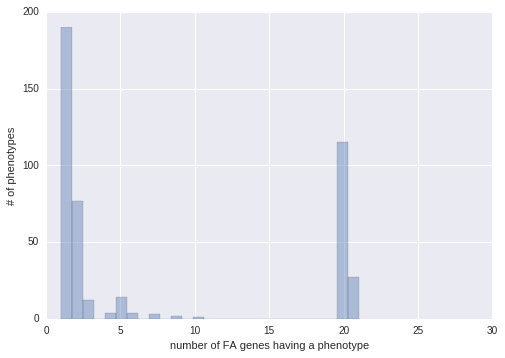

In [19]:
% matplotlib inline
import seaborn as sns
ax = sns.distplot(list(counts.values()), bins=len(human_FA_genes), kde=False)
ax.set_xlabel("number of FA genes having a phenotype")
ax.set_ylabel("# of phenotypes")
ax.set_xbound(0, 30)

In [20]:
taxids = [10090, 7955, 7227, 6239]
results = dict()
for taxid in taxids:
    response = get_phenotypically_similar_genes(phenotypes, taxid)
    results[taxid] = [{"id": r[0], "score": r[1], "symbol": r[2]} for r in response]

In [21]:
results = {k:sorted(v, key=lambda x:x['score'], reverse=True)[:10] for k,v in results.items()}
results_list = list(chain(*results.values()))
for r in results_list:
    r['orthologs'] = query_orthologs(r['id'], "NCBITaxon:9606")

In [22]:
results_list = sorted(results_list, key=lambda x: x['score'], reverse=True)
df = pd.DataFrame(results_list)
df = pd.DataFrame(results_list)
df = df[df.orthologs.map(len)>0]
df1 = df.orthologs.apply(pd.Series).stack().rename('ortholog')
df1 = df1.to_frame().reset_index(1, drop=True)
df = df[['id', 'score', 'symbol']]
df = df.join(df1).reset_index(drop=True)
df['fa'] = df.ortholog.isin(human_FA_genes)
df['ortholog_label'] = df.ortholog.map(lambda x: get_obj(x)['label'])

In [23]:
df

,id,score,symbol,ortholog,fa,ortholog_label
0,MGI:88276,65,Ctnnb1,NCBIGene:1499,False,CTNNB1
1,MGI:108072,64,Traf6,NCBIGene:7189,False,TRAF6
2,MGI:96677,64,Kit,NCBIGene:3815,False,KIT
3,MGI:99851,64,Cbfb,NCBIGene:865,False,CBFB
4,MGI:1347466,64,Foxc1,NCBIGene:2296,False,FOXC1
5,MGI:88039,64,Apc,NCBIGene:324,False,APC
6,MGI:105373,64,Ptch1,NCBIGene:5727,False,PTCH1
7,MGI:97490,63,Pax6,NCBIGene:5080,False,PAX6
8,MGI:98726,63,Tgfb2,NCBIGene:7042,False,TGFB2
9,MGI:88064,63,Ar,NCBIGene:367,False,AR
